# Exercise 2.2 (Solution)
# Node Centrality

__Task 1.__

You should familiarize yourself with the copenhagen dataset. Copenhagen is a Multiplex network of interactions among 845 university students. It provides four types of the tie: physical proximity (bluetooth), calls, short messages (sms), and Facebook friendships. 

More details about the dataset you can find here https://github.com/gesiscss/compsoc/blob/master/copenhagen.ipynb  

You should read the dataset files, select one type of tie (please, do not select bluetooth data), load it into the networkx graph, and draw it. 
If you select call or sms data, you should consider some transformations/grouping of the data. For example, you can group all calls for each user pairs per day and use the sum of call duration as a weight of the edge. 

Answer the following question: Which graph type did you selected for your network, and why? 

Then you should calculate different centralities and store them as columns to the dataframe. Describe why you have made these choices. What are the minings of those centralities for your network?

- Hint: remove users that do not have any ties. We provide you with the code on how to select nodes that are connected with other users. 
- Hint: think of removing/tranforming 0 weights.
- Hint: if you anyways want to select the bluetooth data, you should consider to slice the data to only one day. 

__Task 2.__

Test correlations between different types of centralities. Which classes of centrality are internally correlated but externally uncorrelated?

 - Hint: you can use DataFrame function `corr()` and _seaborn_ library to visualize correlation coefficients' range.

# Task 1

In [1]:
import sys
libs_path = '../libs/'
sys.path.append(libs_path)
import compsoc as cs


import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
users, genders, bluetooth, calls, sms, facebook_friends = cs.copenhagen_collection(path='../../data/copenhagen/')

In [3]:
genders

,gender_id,gender
0,0,male
1,1,female
2,2,unknown


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845 entries, 0 to 844
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    845 non-null    int64
 1   user       845 non-null    int64
 2   gender_id  845 non-null    int32
dtypes: int32(1), int64(2)
memory usage: 23.1 KB


In [5]:
#map gender with colors and add new column node_color to the dataframe
users.loc[:,"node_color"] = pd.Series(cs.partition_to_vertex_property(users['gender_id'],
                                                                      {0: '#e41a1c', 1: '#377eb8', 2: '#4daf4a'}))

## calls


In [6]:
calls

,user_id_from,user_id_to,duration,time,day,hour,minute,second
0,300,301,121,184,0,0,3,4
1,512,299,670,3920,0,1,5,20
2,301,300,504,5623,0,1,33,43
3,401,457,0,9252,0,2,34,12
4,512,0,5,15466,0,4,17,46
...,...,...,...,...,...,...,...,...
3595,706,401,78,2414934,27,22,48,54
3596,218,382,48,2415585,27,22,59,45
3597,561,631,13,2416059,27,23,7,39
3598,323,392,4,2416368,27,23,12,48


In [7]:
calls=calls[calls.day.isin([0,1,2,3,4,5,6,7])]

calls=calls.groupby(["user_id_from","user_id_to"]).sum()[["duration"]].reset_index().rename(columns={"duration":"weight"})

#we can drop column day
calls=calls[[ "user_id_from", "user_id_to", "weight"]]

In [8]:
calls

,user_id_from,user_id_to,weight
0,0,512,3
1,4,424,16
2,6,27,2
3,6,406,52
4,8,419,0
...,...,...,...
338,808,179,10
339,808,656,24
340,840,228,29
341,840,256,48


In [9]:
#there are weights that equal 0
calls[calls.weight<=0]

,user_id_from,user_id_to,weight
4,8,419,0
7,12,13,0
20,33,242,0
31,51,75,0
33,58,672,0
48,92,567,0
49,92,676,0
52,96,109,0
64,128,208,0
65,131,280,0


In [10]:
#change values to small
calls.loc[:,"weight"]=calls.weight.apply(lambda x: 0.1 if x<=0 else x)

#OR
#delete zero values
#calls=calls[calls.weight!=0]

In [12]:
G_Calls = cs.construct_graph(
    directed=True, 
    multiplex=False, 
    graph_name='calls', 
    node_list=users, 
    edge_list=calls, 
    node_color="node_color" 
)

In [29]:
#calculate reversed weight
calls.loc[:,'weight_norm_distance'] = 1./calls.weight
#add attribute to the graph
attr_dict_calls=calls.set_index(['user_id_from', 'user_id_to'])['weight_norm_distance'].to_dict()
nx.set_edge_attributes(G_Calls, values=attr_dict_calls,name='weight_norm_distance')

In [13]:
#use nice positioning for the node
vp_pos = nx.spring_layout(G_Calls, iterations=100)

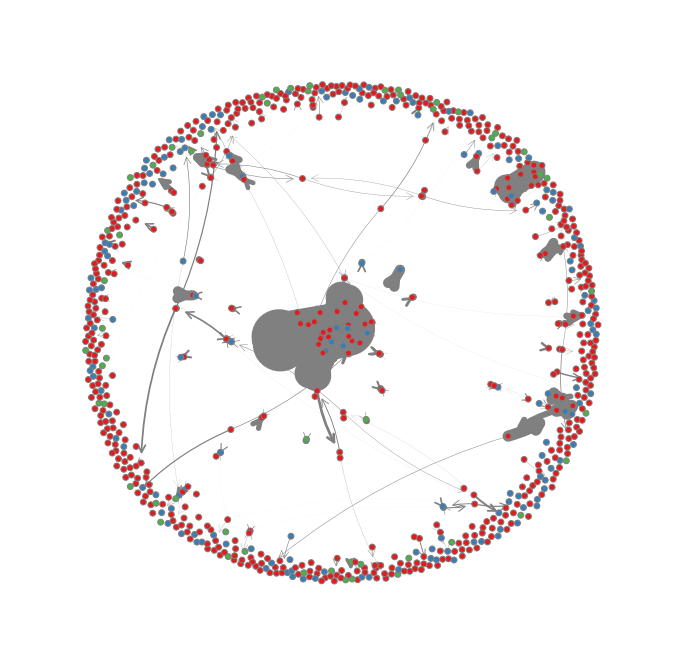

In [14]:
cs.draw_graph( G_Calls, 
    edge_width_factor=0.01,
    node_pos=vp_pos,
    curved_edges=True,
)

In [16]:
users_calls=users.copy()

#You can select the biggest connected component
G_Calls = G_Calls.subgraph(max(nx.connected_components(nx.to_undirected(G_Calls)), key=len))

users_calls=users[users.user_id.isin(list(G_Calls.nodes))]

vp_calls_node_pos = nx.spring_layout(G_Calls, iterations=100)

cs.draw_graph( G_Calls, 
    edge_width_factor=0.1,
    node_pos=vp_calls_node_pos,
    curved_edges=True,
)

In [31]:
users_calls.loc[:,'degree_centrality'] = nx.degree_centrality(G_Calls).values()
users_calls.loc[:,'indegree_centrality'] = nx.in_degree_centrality(G_Calls).values()
users_calls.loc[:,'outdegree_centrality'] = nx.out_degree_centrality(G_Calls).values()
users_calls.loc[:,'degree_centrality_weighted'] = dict(G_Calls.degree(weight='weight')).values()

users_calls.loc[:,'closeness_centrality'] = nx.closeness_centrality(G_Calls).values()
users_calls.loc[:,'closeness_centrality_weighted'] = nx.closeness_centrality(G_Calls,distance="weight_norm_distance").values()

users_calls.loc[:,'betweenness_centrality'] = nx.betweenness_centrality(G_Calls).values()
users_calls.loc[:,'betweenness_centrality_weighted'] = nx.betweenness_centrality(G_Calls,weight="weight_norm_distance").values()

users_calls.loc[:,'pagerank'] = nx.pagerank(G_Calls,alpha=0.9, weight="weight").values()


In [32]:
df_calls=users_calls[['degree_centrality','indegree_centrality','outdegree_centrality',
                      'degree_centrality_weighted',
                    'closeness_centrality','closeness_centrality_weighted',
                    'betweenness_centrality','betweenness_centrality_weighted','pagerank']]

In [73]:
df_calls

,degree_centrality,indegree_centrality,outdegree_centrality,degree_centrality_weighted,closeness_centrality,closeness_centrality_weighted,betweenness_centrality,betweenness_centrality_weighted,pagerank
0,0.003555,0.002370,0.001185,55.0,0.004147,0.002850,0.000028,0.000028,0.000765
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000471
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000471
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000471
4,0.002370,0.001185,0.001185,180.0,0.003773,0.013186,0.000062,0.000062,0.002719
...,...,...,...,...,...,...,...,...,...
840,0.004739,0.001185,0.003555,149.1,0.001185,0.085308,0.000003,0.000003,0.001806
841,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000471
842,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000471
843,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000471


## SMS

In [34]:
sms

,user_id_from,user_id_to,time,day,hour,minute,second
0,370,512,18,0,0,0,18
1,512,370,37,0,0,0,37
2,370,512,126,0,0,2,6
3,0,512,134,0,0,2,14
4,137,136,312,0,0,5,12
...,...,...,...,...,...,...,...
24328,238,26,2415198,27,22,53,18
24329,137,136,2416413,27,23,13,33
24330,136,137,2417238,27,23,27,18
24331,323,392,2417633,27,23,33,53


In [35]:
sms=sms.groupby(['user_id_from', 'user_id_to']).count()["day"].reset_index().rename(columns={'day':'weight'})
sms

,user_id_from,user_id_to,weight
0,0,208,1
1,0,512,61
2,1,345,2
3,3,49,41
4,3,217,3
...,...,...,...
1298,840,256,1
1299,841,191,1
1300,841,291,10
1301,841,374,2


In [36]:
sms.describe()

,user_id_from,user_id_to,weight
count,1303.000000,1303.000000,1303.000000
mean,353.316961,355.705295,18.674597
std,220.090119,220.018563,75.501488
min,0.000000,0.000000,1.000000
25%,164.000000,170.000000,2.000000
50%,345.000000,348.000000,5.000000
75%,531.500000,532.000000,12.000000
max,841.000000,841.000000,1448.000000


In [37]:
sms[sms.weight>500]

,user_id_from,user_id_to,weight
360,176,578,952
543,279,617,1448
896,481,296,515
1051,578,176,812
1110,617,279,1412


In [39]:
G_sms = cs.construct_graph(
    directed=True, 
    multiplex=False, 
    graph_name='sms_count', 
    node_list=users, 
    edge_list=sms, 
    node_label='user',
    node_color="node_color"
)

In [40]:
#calculate reversed weight
sms.loc[:,'weight_norm_distance'] = 1./sms.weight
#add attribute to the graph
attr_dict_sms=sms.set_index(['user_id_from', 'user_id_to'])['weight_norm_distance'].to_dict()
nx.set_edge_attributes(G_sms, values=attr_dict_sms,name='weight_norm_distance')

In [41]:
vp_sms_node_pos = nx.spring_layout(G_sms, iterations=100)


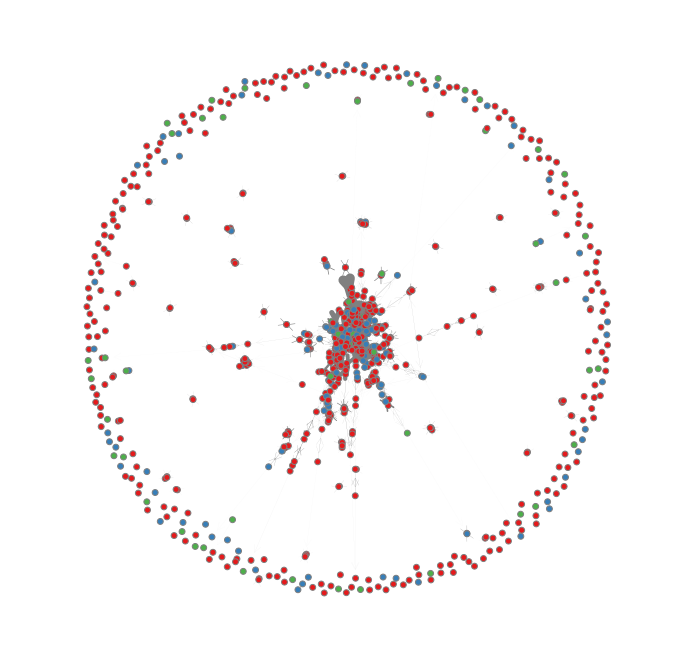

In [42]:
cs.draw_graph(
    G_sms, 
    node_pos=vp_sms_node_pos, 
    edge_width_factor=.01
)

In [43]:
G_sms= G_sms.subgraph(max(nx.connected_components(nx.to_undirected(G_sms)), key=len))

users_sms=users[users.user_id.isin(list(G_sms.nodes))]

vp_sms_node_pos = nx.spring_layout(G_sms, iterations=100)

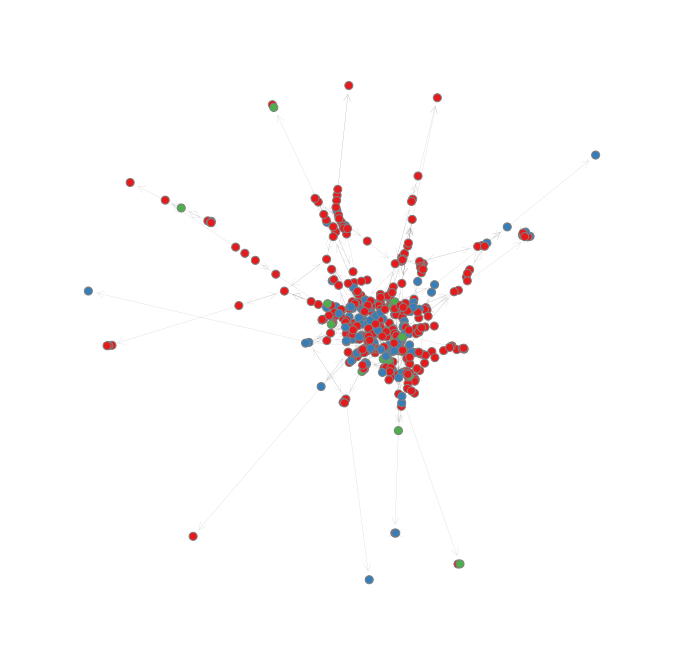

In [44]:
cs.draw_graph(
    G_sms, 
    node_pos=vp_sms_node_pos, 
    edge_width=None,
    edge_width_factor=.1
)

In [45]:
users_sms.loc[:,'degree_centrality'] = nx.degree_centrality(G_sms).values()
users_sms.loc[:,'indegree_centrality'] = nx.in_degree_centrality(G_sms).values()
users_sms.loc[:,'outdegree_centrality'] = nx.out_degree_centrality(G_sms).values()
users_sms.loc[:,'degree_centrality_weighted'] = dict(G_sms.degree(weight='weight')).values()

users_sms.loc[:,'closeness_centrality'] = nx.closeness_centrality(G_sms).values()
users_sms.loc[:,'closeness_centrality_weighted'] = nx.closeness_centrality(G_sms,distance="weight_norm_distance").values()

users_sms.loc[:,'betweenness_centrality'] = nx.betweenness_centrality(G_sms).values()
users_sms.loc[:,'betweenness_centrality_weighted'] = nx.betweenness_centrality(G_sms,weight="weight_norm_distance").values()

users_sms.loc[:,'pagerank'] = nx.pagerank(G_sms,alpha=0.9, weight="weight").values()



C:\Anaconda3\envs\css_ms_38\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\envs\css_ms_38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [46]:
df_sms=users_sms[['degree_centrality','indegree_centrality','outdegree_centrality',
                      'degree_centrality_weighted',
                    'closeness_centrality','closeness_centrality_weighted',
                    'betweenness_centrality','betweenness_centrality_weighted','pagerank']]

## facebook_friends

In [63]:
facebook_friends

,user_id_from,user_id_to
0,0,104
1,0,107
2,0,108
3,0,208
4,0,263
...,...,...
6424,813,826
6425,814,818
6426,816,819
6427,819,831


In [64]:
facebook_friends['weight'] = 1

In [65]:
G_facebook_friends = cs.construct_graph(
    directed=False, #True
    multiplex=False, 
    graph_name='facebook_friends', 
    node_list=users, 
    edge_list=facebook_friends, 
    node_label='user',
    node_color="node_color"
)

In [66]:
G_facebook_friends = G_facebook_friends.subgraph(max(nx.connected_components(nx.to_undirected(G_facebook_friends)),
                                                     key=len))

users_facebook=users[users.user_id.isin(list(G_facebook_friends.nodes))]

vp_facebook_friends_node_pos = nx.spring_layout(G_facebook_friends, iterations=100)

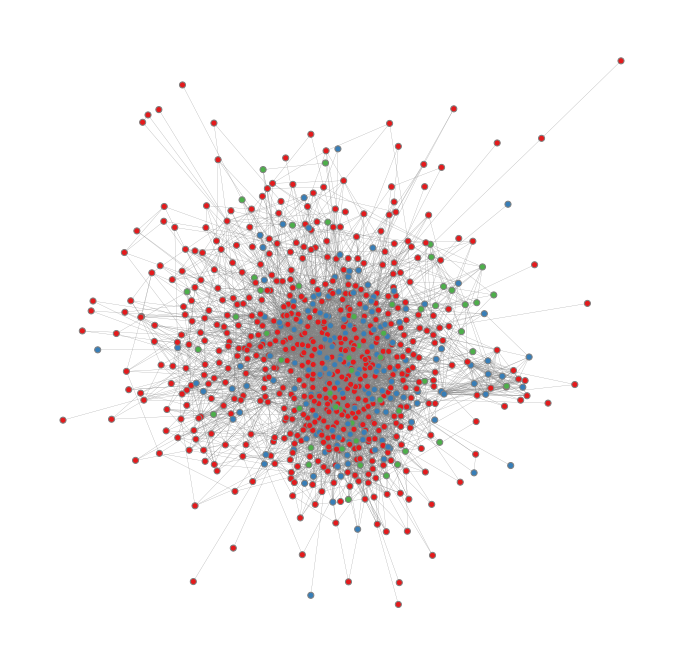

In [67]:
cs.draw_graph(
    G_facebook_friends, 
    node_pos=vp_facebook_friends_node_pos, 
    node_border_width=1, 
    edge_width_factor=.2, 
    figsize='large'
)

In [68]:
users_facebook.loc[:,'degree_centrality'] = nx.degree_centrality(G_facebook_friends).values()
#users_facebook.loc[:,'indegree_centrality'] = nx.in_degree_centrality(G_facebook_friends).values()
#users_facebook.loc[:,'outdegree_centrality'] = nx.out_degree_centrality(G_facebook_friends).values()

users_facebook.loc[:,'closeness_centrality'] = nx.closeness_centrality(G_facebook_friends).values()
users_facebook.loc[:,'betweenness_centrality'] = nx.betweenness_centrality(G_facebook_friends).values()
users_facebook.loc[:,'pagerank'] = nx.pagerank(G_facebook_friends,alpha=0.9).values()

C:\Anaconda3\envs\css_ms_38\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\envs\css_ms_38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [69]:
df_facebook=users_facebook[['degree_centrality','closeness_centrality','betweenness_centrality','pagerank']]

## bluetooth

In [47]:
#First type of tie: Network of physical proximity among the participants (estimated via Bluetooth signal strength).
bluetooth

,user_id_from,user_id_to,strength,time,day,hour,minute,second
0,12,244,30,0,0,0,0,0
1,12,454,25,0,0,0,0,0
2,16,572,30,0,0,0,0,0
3,19,47,14,0,0,0,0,0
4,20,21,27,0,0,0,0,0
...,...,...,...,...,...,...,...,...
4852545,702,194,17,2418900,27,23,55,0
4852546,702,259,42,2418900,27,23,55,0
4852547,702,294,6,2418900,27,23,55,0
4852548,702,359,6,2418900,27,23,55,0


In [48]:
bluetooth=bluetooth[bluetooth.day==0]

In [49]:
bluetooth.groupby(["user_id_from","user_id_to"]).count()[["strength"]]

strength
user_id_from user_id_to          
0            165                4
             208               20
             340               31
             405               19
             654                2
...                           ...
677          364                1
             370               10
             401                3
             411                2
             634               29

[1310 rows x 1 columns]

In [50]:
bluetooth=bluetooth.groupby(["user_id_from",
                             "user_id_to"]).count()[["strength"]].reset_index().rename(columns={"strength":"weight"})

In [51]:
bluetooth

,user_id_from,user_id_to,weight
0,0,165,4
1,0,208,20
2,0,340,31
3,0,405,19
4,0,654,2
...,...,...,...
1305,677,364,1
1306,677,370,10
1307,677,401,3
1308,677,411,2


In [52]:
#you can create network where gender is represented with the node shape
'''g = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='bluetoth_proximity', 
    node_list=users_bluetooth, 
    edge_list=bluetooth, 
    node_shape='gender_id', )
cs.draw_graph(g, labels='no text')
'''

#OR
#use node color for gender

G = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='bluetoth_proximity', 
    node_list=users, 
    edge_list=bluetooth, 
    node_color="node_color" 
)

In [53]:
#calculate reversed weight
bluetooth.loc[:,'weight_norm_distance'] = 1./bluetooth.weight

#add attribute to the graph
attr_dict_bluetooth=bluetooth.set_index(['user_id_from', 'user_id_to'])['weight_norm_distance'].to_dict()
nx.set_edge_attributes(G, values=attr_dict_bluetooth,name='weight_norm_distance')

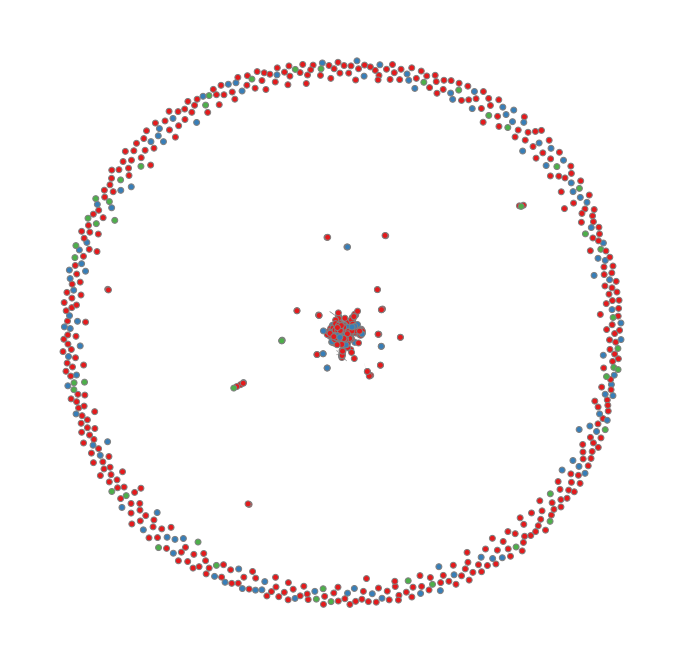

In [54]:
#use nice positioning for the node
vp_pos = nx.spring_layout(G, iterations=100)

#draw the network
cs.draw_graph( G, 
    edge_width_factor=0.1,
    node_pos=vp_pos
)

In [55]:
#Here is the simple code that would help you to select only nodes that are connected between each other.
#The group of such nodes is called the biggest connected component
G = G.subgraph(max(nx.connected_components(nx.to_undirected(G)), key=len))

users_bluetooth=users[users.user_id.isin(list(G.nodes))]

vp_pos = nx.spring_layout(G, iterations=100)

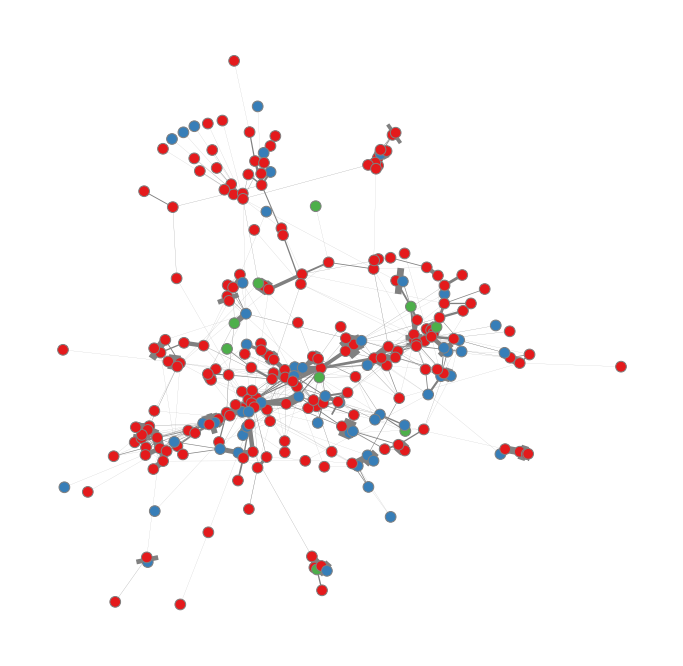

In [56]:
cs.draw_graph( G, 
    edge_width_factor=0.1,
    node_pos=vp_pos
)

In [57]:
## add your code here
users_bluetooth.loc[:,'degree_centrality'] = nx.degree_centrality(G).values()
users_bluetooth.loc[:,'degree_centrality_weighted'] = dict(G.degree(weight='weight')).values()

users_bluetooth.loc[:,'closeness_centrality'] = nx.closeness_centrality(G).values()
users_bluetooth.loc[:,'closeness_centrality_weighted'] = nx.closeness_centrality(G,distance="weight_norm_distance").values()

users_bluetooth.loc[:,'betweenness_centrality'] = nx.betweenness_centrality(G).values()
users_bluetooth.loc[:,'betweenness_centrality_weighted'] = nx.betweenness_centrality(G,weight="weight_norm_distance").values()

users_bluetooth.loc[:,'pagerank'] = nx.pagerank(G,alpha=0.9, weight="weight").values()


C:\Anaconda3\envs\css_ms_38\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\envs\css_ms_38\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [58]:
df=users_bluetooth[['degree_centrality','degree_centrality_weighted',
                    'closeness_centrality','closeness_centrality_weighted',
                    'betweenness_centrality','betweenness_centrality_weighted','pagerank']]

In [59]:
df

,degree_centrality,degree_centrality_weighted,closeness_centrality,closeness_centrality_weighted,betweenness_centrality,betweenness_centrality_weighted,pagerank
0,0.019380,76,0.203470,0.851769,0.001502,0.000060,0.003139
2,0.007752,43,0.200155,0.619045,0.000898,0.000513,0.003970
3,0.011628,174,0.156174,0.614434,0.000000,0.000000,0.003885
5,0.023256,15,0.251707,1.182322,0.034006,0.030646,0.000859
11,0.003876,53,0.188596,0.748236,0.000000,0.000000,0.006505
...,...,...,...,...,...,...,...
657,0.015504,17,0.198462,0.972619,0.009577,0.000181,0.000894
664,0.015504,6,0.219574,0.824881,0.035389,0.000000,0.000545
665,0.003876,1,0.215000,0.496619,0.000000,0.000000,0.000469
673,0.038760,44,0.251217,0.976003,0.033413,0.007993,0.003372


# Task 2

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix

corr = df.corr()

In [61]:
corr

,degree_centrality,degree_centrality_weighted,closeness_centrality,closeness_centrality_weighted,betweenness_centrality,betweenness_centrality_weighted,pagerank
degree_centrality,1.000000,0.460253,0.712334,0.592721,0.704961,0.606822,0.551290
degree_centrality_weighted,0.460253,1.000000,0.236264,0.474079,0.255303,0.444379,0.768600
closeness_centrality,0.712334,0.236264,1.000000,0.676375,0.621428,0.514646,0.296977
closeness_centrality_weighted,0.592721,0.474079,0.676375,1.000000,0.294990,0.425774,0.375732
betweenness_centrality,0.704961,0.255303,0.621428,0.294990,1.000000,0.664625,0.483159
betweenness_centrality_weighted,0.606822,0.444379,0.514646,0.425774,0.664625,1.000000,0.462924
pagerank,0.551290,0.768600,0.296977,0.375732,0.483159,0.462924,1.000000


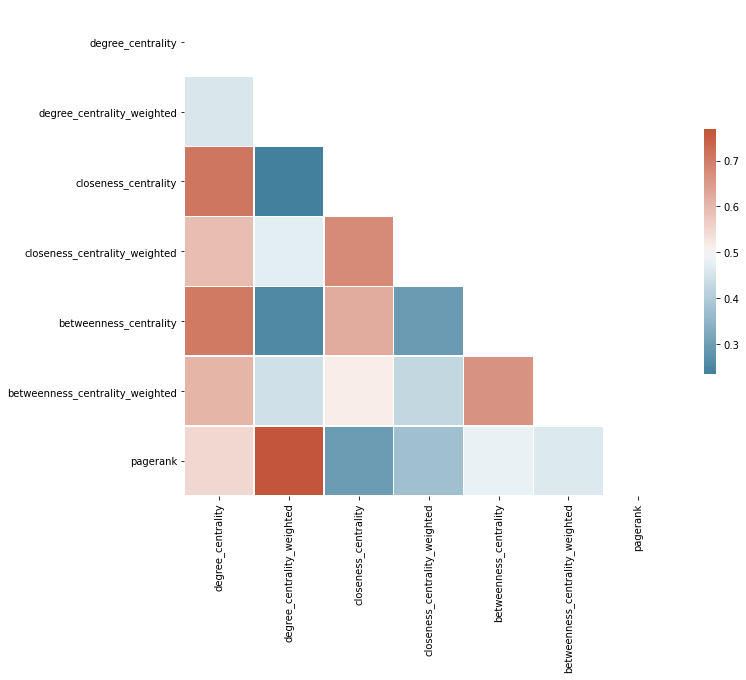

In [62]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0.5,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Plot for all other ties

In [74]:
corr_calls=df_calls.corr()
corr_calls

,degree_centrality,indegree_centrality,outdegree_centrality,degree_centrality_weighted,closeness_centrality,closeness_centrality_weighted,betweenness_centrality,betweenness_centrality_weighted,pagerank
degree_centrality,1.000000,0.883453,0.900434,0.364170,0.832054,0.170479,0.548065,0.558368,0.610353
indegree_centrality,0.883453,1.000000,0.591687,0.339630,0.939423,0.181460,0.465796,0.476041,0.634539
outdegree_centrality,0.900434,0.591687,1.000000,0.311290,0.559491,0.124862,0.510573,0.518790,0.461082
degree_centrality_weighted,0.364170,0.339630,0.311290,1.000000,0.299700,0.583619,0.106622,0.107486,0.441842
closeness_centrality,0.832054,0.939423,0.559491,0.299700,1.000000,0.131995,0.537912,0.546382,0.566197
closeness_centrality_weighted,0.170479,0.181460,0.124862,0.583619,0.131995,1.000000,-0.014929,-0.014036,0.249660
betweenness_centrality,0.548065,0.465796,0.510573,0.106622,0.537912,-0.014929,1.000000,0.995950,0.164503
betweenness_centrality_weighted,0.558368,0.476041,0.518790,0.107486,0.546382,-0.014036,0.995950,1.000000,0.167323
pagerank,0.610353,0.634539,0.461082,0.441842,0.566197,0.249660,0.164503,0.167323,1.000000


In [76]:
corr_sms=df_sms.corr()
corr_sms

,degree_centrality,indegree_centrality,outdegree_centrality,degree_centrality_weighted,closeness_centrality,closeness_centrality_weighted,betweenness_centrality,betweenness_centrality_weighted,pagerank
degree_centrality,1.000000,0.983275,0.984023,0.250876,0.465411,0.430999,0.840092,0.645518,0.576252
indegree_centrality,0.983275,1.000000,0.935138,0.237083,0.492360,0.444810,0.824944,0.635767,0.570315
outdegree_centrality,0.984023,0.935138,1.000000,0.256249,0.424022,0.403565,0.827742,0.634182,0.563427
degree_centrality_weighted,0.250876,0.237083,0.256249,1.000000,0.105632,0.138477,0.193025,0.217588,0.603234
closeness_centrality,0.465411,0.492360,0.424022,0.105632,1.000000,0.869514,0.445809,0.370978,0.223568
closeness_centrality_weighted,0.430999,0.444810,0.403565,0.138477,0.869514,1.000000,0.384859,0.399627,0.260147
betweenness_centrality,0.840092,0.824944,0.827742,0.193025,0.445809,0.384859,1.000000,0.747643,0.434865
betweenness_centrality_weighted,0.645518,0.635767,0.634182,0.217588,0.370978,0.399627,0.747643,1.000000,0.472606
pagerank,0.576252,0.570315,0.563427,0.603234,0.223568,0.260147,0.434865,0.472606,1.000000


In [77]:
corr_facebook=df_facebook.corr()
corr_facebook

,degree_centrality,closeness_centrality,betweenness_centrality,pagerank
degree_centrality,1.000000,0.862831,0.863518,0.994351
closeness_centrality,0.862831,1.000000,0.666136,0.845487
betweenness_centrality,0.863518,0.666136,1.000000,0.887141
pagerank,0.994351,0.845487,0.887141,1.000000


========  Bluetooth ==============


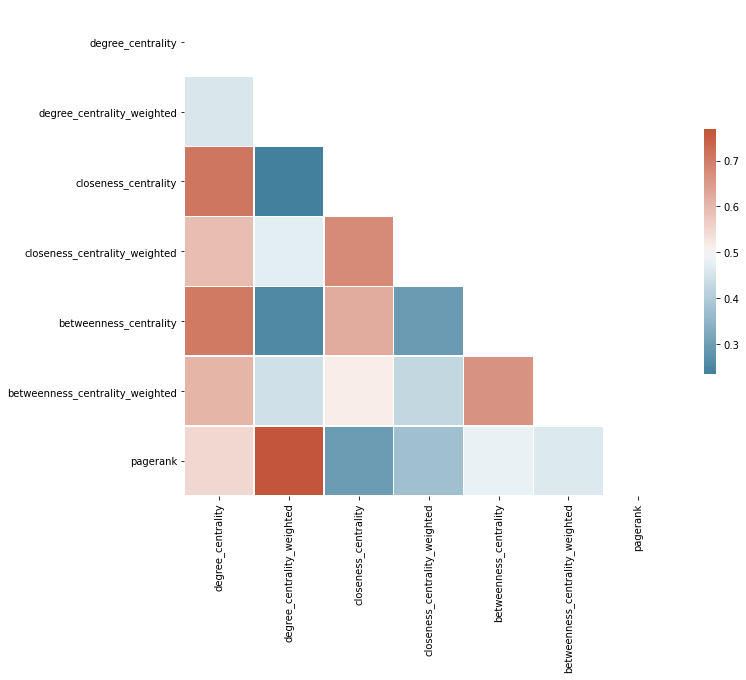

========  Calls ==============


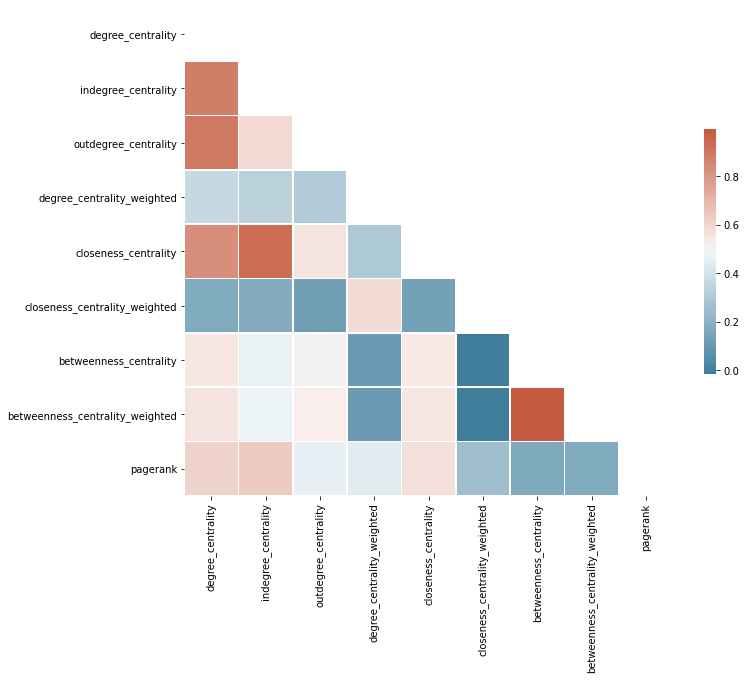

========  SMS ==============


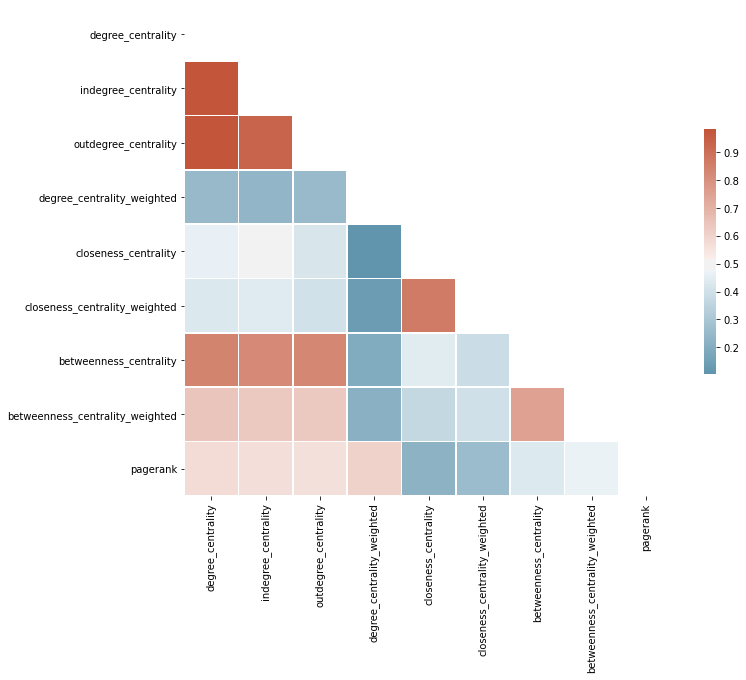

========  Facebook freinds ==============


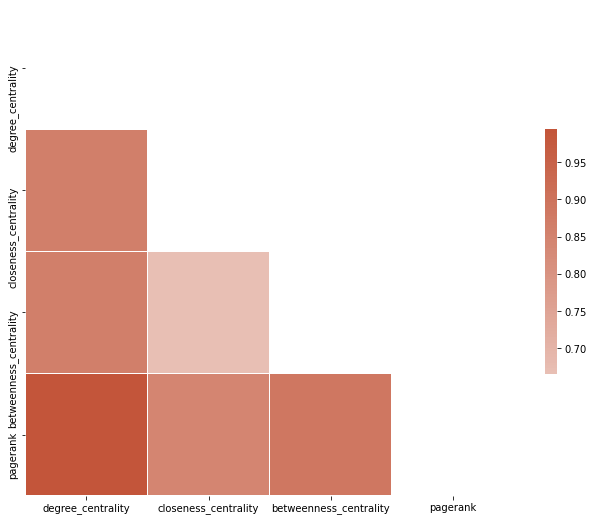

In [78]:
for corr_n,name in zip([corr, corr_calls,corr_sms, corr_facebook],["Bluetooth","Calls","SMS","Facebook freinds"]):
    print ("======== ",name, "==============")
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_n, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_n, mask=mask, cmap=cmap, center=0.5,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()